In [1]:
from drn_interactions.config import ExperimentInfo, Config
from drn_interactions.io import load_derived_generic, load_recordings
from drn_interactions.transforms import SpikesHandler
import numpy as np
import pandas as pd
from drn_interactions.plots.drug import population_raster
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context="paper", style="ticks")
%load_ext autoreload
%autoreload 2

def load_drug_data(
    block="chal", 
    t_start=-600, 
    t_stop=1200, 
    bin_width=1,
    sessions=None,
    group_names=None,
    ):
    df_binned = SpikesHandler(
        block=block,
        bin_width=bin_width,
        session_names=sessions,
        t_start=t_start,
        t_stop=t_stop,
    ).binned
    df_binned["block"] = np.where(df_binned["bin"] < 0, "pre", "post")
    neuron_types = (
        load_derived_generic("neuron_types.csv")
        [["neuron_id", "neuron_type", "session_name", "group_name"]]
        .assign(neuron_type = lambda x: pd.Categorical(x["neuron_type"], ["SR", "SIR", "FF"]))
    )
    df_binned = df_binned.merge(neuron_types)
    if group_names is not None:
        df_binned = df_binned.query("group_name in @group_names")
    return df_binned

def get_group_sessions(group_names):
    df_recordings = load_recordings()
    if not hasattr(group_names, "__iter__"):
        group_names = [group_names]
    return (
        df_recordings
        .query("group_name in @group_names")["session_name"]
        .unique()
        .tolist()
    )


In [2]:
cit_sessions = get_group_sessions(ExperimentInfo.cit_groups)
sal_sessions = get_group_sessions(ExperimentInfo.sal_groups)
way_sessions = ExperimentInfo.way_sessions

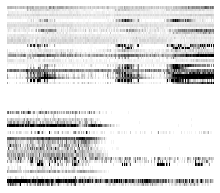

In [3]:


cit_session = cit_sessions[5]
sal_session = sal_sessions[4]
df_cit = load_drug_data(sessions=[cit_session])
df_sal = load_drug_data(sessions=[sal_session])

idx_cit = df_cit.sort_values("neuron_type")[["neuron_id"]].drop_duplicates().neuron_id.values
idx_sal = df_sal.sort_values("neuron_type")[["neuron_id"]].drop_duplicates().neuron_id.values

f = plt.figure(figsize=(3.7, 3.3))
axes =f.subplots(2, 1, gridspec_kw=dict(hspace=0.3))

population_raster(
    session_name=sal_session, 
    tfidf=False, 
    idx=idx_sal,
    title=False,
    ax=axes[0],
    )
population_raster(
    session_name=cit_session, 
    tfidf=False, 
    idx=idx_cit,
    title=False,
    ax=axes[1],
    )

f.savefig(Config.fig_dir / "cit_heats.png", dpi=300)

In [18]:
from scipy.stats import zscore, zmap

def pct_pre(x, idx_base):
    return x / np.nanmean(x[:idx_base]) * 100

df = (
    load_drug_data()
    .assign(drug=lambda x: x.group_name.str.contains("cit").map({True: "CIT", False: "SAL"}))
    .assign(drug=lambda x: pd.Categorical(x["drug"], [ "SAL", "CIT"]))
    .assign(zcounts=lambda x: x.groupby(["neuron_id"])["counts"].transform(lambda x: zmap(x, x[:600]), ))
    .assign(pct_pre=lambda x: x.groupby(["neuron_id"])["counts"].transform(lambda x: pct_pre(x, 600), ))
)

c:\Users\roryl\.conda\envs\drn38\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\roryl\.conda\envs\drn38\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


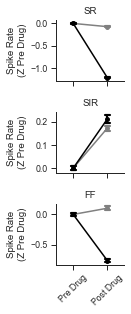

In [21]:
from drn_interactions.plots import PAL_GREY_BLACK

g = sns.catplot(
    x="block", 
    y="zcounts", 
    row="neuron_type", 
    hue="drug",
    sharey=False,
    sharex=True,
    capsize=0.15, 
    height=1.5, 
    aspect=0.8, 
    color="black",
    kind="point", 
    data=df,
    scale=0.7,
    facet_kws=dict(gridspec_kws=dict(hspace=0.5)),
    palette=sns.color_palette(["grey" ,"black"])
)

g.set_xlabels("")
g.set_ylabels("Spike Rate\n(Z Pre Drug)")
g.set_titles("{row_name}")
g.set_xticklabels(["Pre Drug", "Post Drug"], rotation=45)
g.despine()
g.legend.remove()
g.figure.align_ylabels()
g.savefig(Config.fig_dir / "cit_catplot.png", dpi=300)

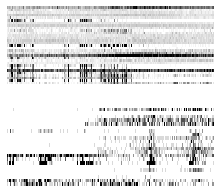

In [61]:
# WAY

# Example Raster Heat: CIT
# Example Raster Heat: SAL


f = plt.figure(figsize=(3.7, 3.3))
axes =f.subplots(2, 1, gridspec_kw=dict(hspace=0.3))

population_raster(
    session_name=sal_session, 
    block="way",
    tfidf=False, 
    idx=idx_sal,
    title=False,
    ax=axes[0],
    )
population_raster(
    session_name=cit_session, 
    block="way",
    tfidf=False, 
    idx=idx_cit,
    title=False,
    ax=axes[1],
    )

f.savefig(Config.fig_dir / "way_heats.png", dpi=300)

c:\Users\roryl\.conda\envs\drn38\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\roryl\.conda\envs\drn38\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


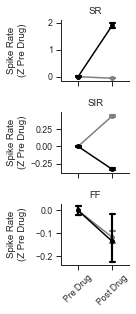

In [65]:
# Catplot

from scipy.stats import zscore, zmap


df = (
    load_drug_data(block="way")
    .assign(drug=lambda x: x.group_name.str.contains("cit").map({True: "CIT", False: "SAL"}))
    .assign(drug=lambda x: pd.Categorical(x["drug"], [ "SAL", "CIT"]))
    .assign(zcounts=lambda x: x.groupby(["neuron_id"])["counts"].transform(lambda x: zmap(x, x[:600]), ))
    .assign(pct_pre=lambda x: x.groupby(["neuron_id"])["counts"].transform(lambda x: pct_pre(x, 600), ))
)



g = sns.catplot(
    x="block", 
    y="zcounts", 
    row="neuron_type", 
    hue="drug",
    sharey=False,
    sharex=True,
    capsize=0.15, 
    height=1.5, 
    aspect=0.8, 
    color="black",
    kind="point", 
    data=df,
    scale=0.7,
    facet_kws=dict(gridspec_kws=dict(hspace=0.5)),
    palette=sns.color_palette(["grey" ,"black"])
)

g.set_xlabels("")
g.set_ylabels("Spike Rate\n(Z Pre Drug)")
g.set_titles("{row_name}")
g.set_xticklabels(["Pre Drug", "Post Drug"], rotation=45)
g.despine()
g.legend.remove()
g.figure.align_ylabels()
g.savefig(Config.fig_dir / "way_catplot.png", dpi=300)